In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [3]:
df = pd.read_csv('./data/titanic_data.csv')
df.head()

Pclass                                             Name     Sex   Age   
0       1                    Allen, Miss. Elisabeth Walton  female  29.0  \
1       1                   Allison, Master. Hudson Trevor    male   1.0   
2       1                     Allison, Miss. Helen Loraine  female   2.0   
3       1             Allison, Mr. Hudson Joshua Creighton    male  30.0   
4       1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0   

   SibSp  Parch  Ticket    Fare    Cabin Embarked  Survived  
0      0      0   24160  211.34       B5        S         1  
1      1      2  113781  151.55  C22 C26        S         1  
2      1      2  113781  151.55  C22 C26        S         0  
3      1      2  113781  151.55  C22 C26        S         0  
4      1      2  113781  151.55  C22 C26        S         0

In [6]:
df["Embarked"].unique()

array(['S', 'C', nan, 'Q'], dtype=object)

# Data Cleanup

In [7]:
#Age is skewed and has a significant number of missing values so best to replace missing values with median of data
age_median = df['Age'].median(skipna=True)
df['Age'].fillna(age_median, inplace=True)

#Embarked only has 2 missing values and can be replaced with the most common which is S
df['Embarked'].fillna("S", inplace=True)

#Fare has one missing value and can be replaced with the median because it is highly skewed
fare_median = df['Fare'].median(skipna=True)
df['Fare'].fillna(fare_median,inplace=True)

#SibSp - Number of siblings/spouses aboard
#Parch - Number of parents/children aboard
#These two variables overlap for every passenger that has this data so I am creating a variable that just detects 
#whether someone is traveling alone or not to account for multicollinearity
df['TravelGroup']=df["SibSp"]+df["Parch"]
df['TravelAlone']=np.where(df['TravelGroup']>0, 0, 1) 
#Does total size of group change the probability of surviving? 
#Initial thought: People who want to check up on the safety of more people take more time looking for them 
#and die as a result of not trying to escape
df['TravelTotal'] = df['TravelGroup'] + 1

#Drop unnecessary variables   - thanks for the help Jeffrey!
df.drop('SibSp', axis=1, inplace=True)
df.drop('Parch', axis=1, inplace=True)
df.drop('TravelGroup', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
df.drop('Name', axis=1, inplace=True)

df.head()

Pclass     Sex   Age    Fare    Cabin Embarked  Survived  TravelAlone   
0       1  female  29.0  211.34       B5        S         1            1  \
1       1    male   1.0  151.55  C22 C26        S         1            0   
2       1  female   2.0  151.55  C22 C26        S         0            0   
3       1    male  30.0  151.55  C22 C26        S         0            0   
4       1  female  25.0  151.55  C22 C26        S         0            0   

   TravelTotal  
0            1  
1            4  
2            4  
3            4  
4            4

In [8]:
le = preprocessing.LabelEncoder()
pclass_cat = le.fit_transform(df.Pclass)
sex_cat = le.fit_transform(df.Sex)
embarked_cat = le.fit_transform(df.Embarked)

data_proc = df
#Initialize the encoded categorical columns
data_proc['pclass_cat'] = pclass_cat
data_proc['sex_cat'] = sex_cat
data_proc['embarked_cat'] = embarked_cat

#Drop old categorical fields from dataframe and reindex
dummy_fields = ['Pclass','Sex','Embarked']
data_proc = data_proc.drop(dummy_fields, axis = 1)
data_proc = data_proc.reindex(['pclass_cat','sex_cat','Age','Fare','embarked_cat','TravelAlone', 'TravelTotal','Survived'],axis=1)

#Make sure data is clean/check for null
data_proc[data_proc.isnull().any(axis=1)].head()

data = data_proc
data

pclass_cat  sex_cat   Age    Fare  embarked_cat  TravelAlone   
0              0        0  29.0  211.34             2            1  \
1              0        1   1.0  151.55             2            0   
2              0        0   2.0  151.55             2            0   
3              0        1  30.0  151.55             2            0   
4              0        0  25.0  151.55             2            0   
...          ...      ...   ...     ...           ...          ...   
1304           2        0  15.0   14.45             0            0   
1305           2        0  28.0   14.45             0            0   
1306           2        1  27.0    7.23             0            1   
1307           2        1  27.0    7.23             0            1   
1308           2        1  29.0    7.88             2            1   

      TravelTotal  Survived  
0               1         1  
1               4         1  
2               4         0  
3               4         0  
4               4         0  
...           ...       ...  
1304            2         0  
1305            2         0  
1306            1         0  
1307            1         0  
1308            1         0  

[1309 rows x 8 columns]

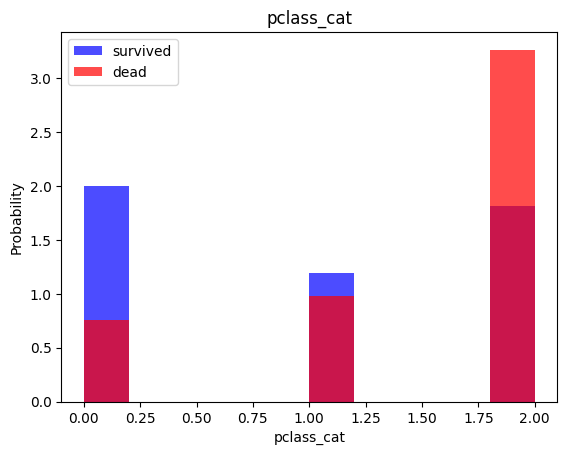

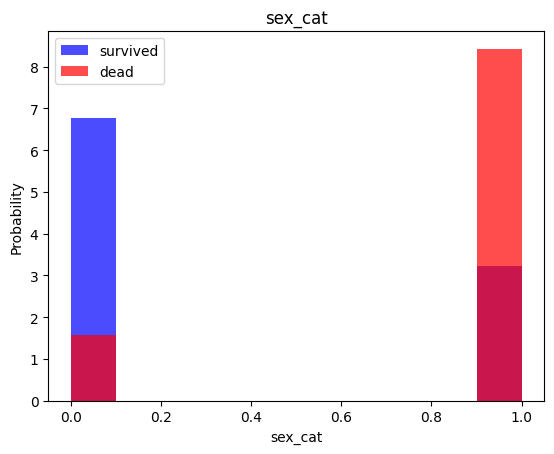

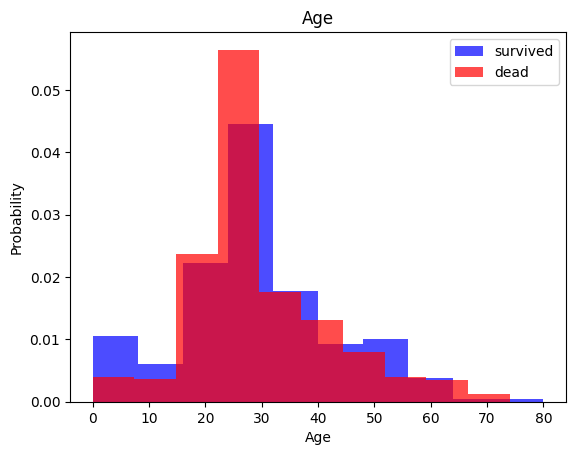

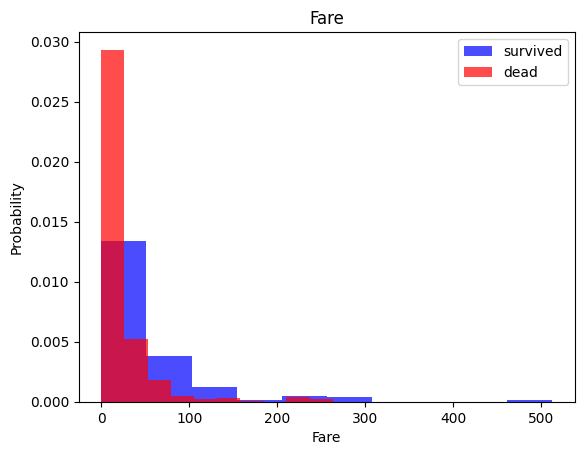

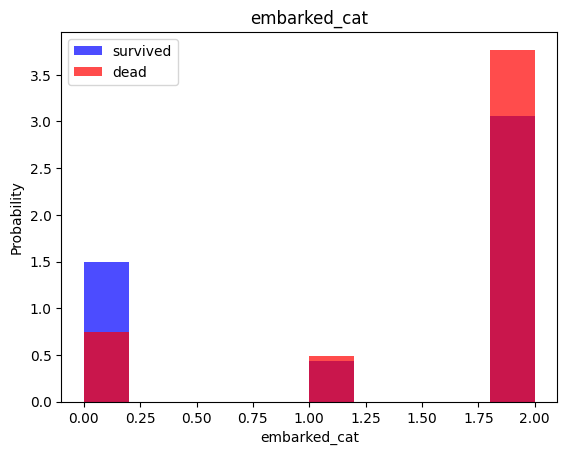

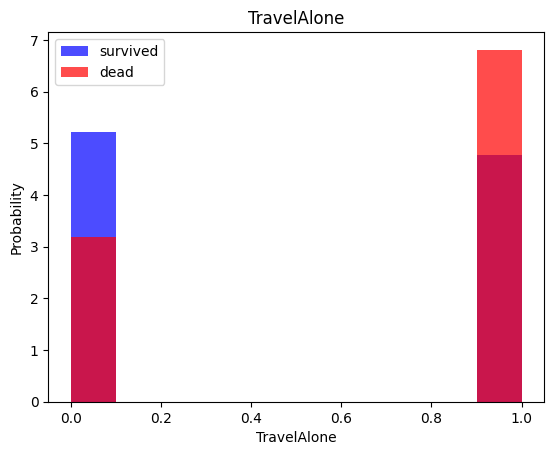

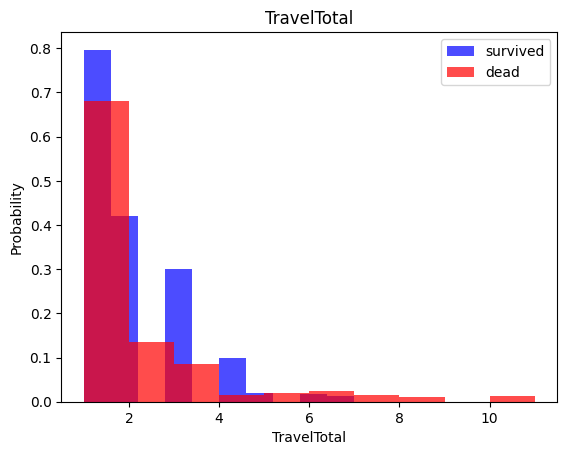

In [15]:
for label in data.columns[:-1]:
    plt.hist(data[data["Survived"]==1][label], color='blue', label='survived', alpha=0.7, density=True)
    plt.hist(data[data["Survived"]==0][label], color='red', label='dead', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.legend()
    plt.show()


# data.columns

In [9]:
train, valid, test = np.split(data.sample(frac=1), [int(0.6*len(data)), int(0.8*len(data))])

In [10]:
valid

pclass_cat  sex_cat   Age    Fare  embarked_cat  TravelAlone   
587           1        1   2.0   23.00             2            0  \
214           0        0  23.0  113.28             0            0   
12            0        0  24.0   69.30             0            1   
488           1        1  50.0   26.00             2            0   
115           0        1  64.0  263.00             2            0   
..          ...      ...   ...     ...           ...          ...   
884           2        1  48.0    7.85             2            1   
622           2        1   4.0   31.28             2            0   
162           0        1  42.0   52.00             2            0   
518           1        1  19.0   36.75             2            0   
674           2        1  32.0   56.50             2            1   

     TravelTotal  Survived  
587            3         1  
214            2         1  
12             1         1  
488            2         0  
115            6         0  
..           ...       ...  
884            1         0  
622            7         0  
162            2         0  
518            3         0  
674            1         1  

[262 rows x 8 columns]

In [11]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    Y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # print(f"X: {X[0]}")
    # print(f"Y: {np.reshape(Y, (-1, 1))[0]}")

    if oversample:
        ros = RandomOverSampler()
        X, Y = ros.fit_resample(X, Y)
    data = np.hstack((X, np.reshape(Y, (-1, 1))))
    # print(f"data: {data[0]}")
    return data, X, Y

In [12]:
train_os, x_train_os, y_train_os = scale_dataset(train, oversample = True)
train_s, x_train_s, y_train_s = scale_dataset(train)

valid_s, x_valid_s, y_valid_s = scale_dataset(valid)
test_s, x_test_s, y_test_s = scale_dataset(test)



In [17]:
x_valid_s.shape

(262, 7)

# kNN [K nearest neighbors]

In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [158]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train_s, y_train_s)

KNeighborsClassifier()

In [163]:
y_pred = knn_model.predict(x_test_s)
print(classification_report(y_test_s, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       154
           1       0.78      0.68      0.72       108

    accuracy                           0.79       262
   macro avg       0.78      0.77      0.77       262
weighted avg       0.79      0.79      0.78       262



# Naive Bayes

In [161]:
from sklearn.naive_bayes import GaussianNB

In [162]:
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train_s, y_train_s)

In [164]:
y_pred = nb_model.predict(x_test_s)
print(classification_report(y_test_s, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       154
           1       0.79      0.65      0.71       108

    accuracy                           0.78       262
   macro avg       0.78      0.76      0.77       262
weighted avg       0.78      0.78      0.78       262



# LOGISTIC REGRESSION

In [165]:
from sklearn.linear_model import LogisticRegression

In [166]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(x_train_s, y_train_s)

In [167]:
y_pred = lg_model.predict(x_test_s)
print(classification_report(y_test_s, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       154
           1       0.82      0.74      0.78       108

    accuracy                           0.83       262
   macro avg       0.83      0.82      0.82       262
weighted avg       0.83      0.83      0.83       262



# Support Vector Machines (SVM)

In [168]:
from sklearn.svm import SVC

In [169]:
svm_model = SVC()
svm_model = svm_model.fit(x_train_s, y_train_s)

In [170]:
y_pred = svm_model.predict(x_test_s)
print(classification_report(y_test_s, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       154
           1       0.84      0.70      0.77       108

    accuracy                           0.82       262
   macro avg       0.83      0.81      0.81       262
weighted avg       0.83      0.82      0.82       262



# Neural Net

In [172]:
import tensorflow as tf

In [175]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [190]:
#use the same data for validation

def train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(7,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

#use separate data for validation
def train_model2(x_train, y_train, x_valid, y_valid, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(7,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_valid, y_valid)
, verbose=0
  )

  return nn_model, history

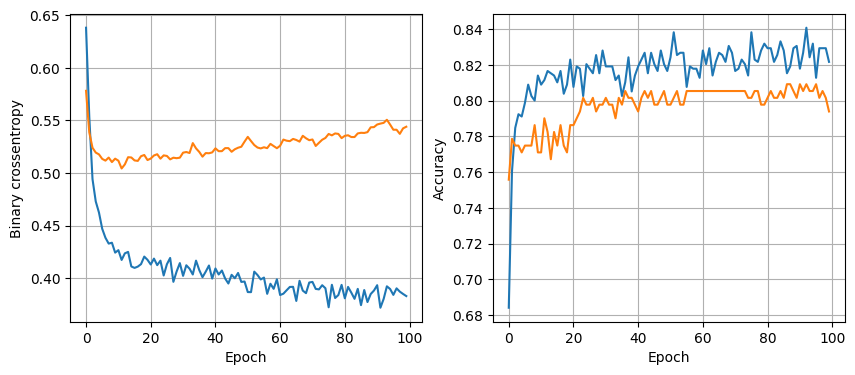

9/9 [==============================] - 0s 4ms/step - loss: 0.5440 - accuracy: 0.7939
[0.5440375208854675, 0.7938931584358215]


In [197]:
# n_model, history = train_model(x_train_s, y_train_s, 32, 0.2, 0.001, 32, 100)
# plot_history(history)
n_model, history = train_model2(x_train_s, y_train_s, x_valid_s, y_valid_s, 64, 0.2, 0.001, 64, 100)
plot_history(history)
val_loss = n_model.evaluate(x_valid_s, y_valid_s)
print(val_loss)

In [200]:
y_pred = n_model.predict(x_test_s)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
y_pred

9/9 [==============================] - 0s 2ms/step


array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0])

In [201]:
print(classification_report(y_test_s, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       154
           1       0.84      0.65      0.73       108

    accuracy                           0.81       262
   macro avg       0.82      0.78      0.79       262
weighted avg       0.81      0.81      0.80       262



In [14]:
print(y_test_s)

[0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1
 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0
 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1
 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 1 1 0]
